In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [4]:
device

device(type='cuda')

## Implementing Generator and Discriminator

In [5]:
noise_dim = 100

In [6]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=noise_dim,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            
            torch.nn.Linear(
                in_features=1200,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            
            torch.nn.Linear(
                in_features=1200,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            
            torch.nn.Linear(
                in_features=1200,
                out_features=784
            ),
            torch.nn.Sigmoid()
        )
        
    def forward(self, batch):
        ret = batch.view(batch.size(0), -1)
        ret = self.fcn(ret)
        return ret
         

In [7]:
class Maxout(torch.nn.Module):
    def __init__(self, num_pieces):
        super(Maxout, self).__init__()
        
        self.num_pieces = num_pieces
        
    def forward(self, x):
        assert x.shape[1] % self.num_pieces == 0
        
        ret = x.view(
            *x.shape[:1], # batch_size
            x.shape[1] // self.num_pieces, # piece-wise linear
            self.num_pieces,
            *x.shape[2:] # remaining dimensions if any
        )
        
        ret, _ = ret.max(dim=2)
        
        return ret

In [8]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=784,
                out_features=625,
                bias=True
            ),
            Maxout(5),
            
            torch.nn.Linear(
                in_features=125,
                out_features=625,
                bias=True
            ),
            Maxout(5),
            
            torch.nn.Linear(
                in_features=125,
                out_features=1,
                bias=True
            ),
            torch.nn.Sigmoid()
        )
    
    def forward(self, batch):
        ret = batch.view(batch.size(0), -1)
        ret = self.fcn(ret)
        return ret

## Training GAN on MNIST Dataset

In [9]:
import torchvision

In [10]:
class FlattenTransform:
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)

In [11]:
data_train = torchvision.datasets.MNIST(
    './data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        FlattenTransform()
    ])
)

In [12]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

In [13]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

discriminator_optimizer = torch.optim.SGD(
    discriminator.parameters(),
    lr=0.0005,
    momentum=0.7
)

generator_optimizer = torch.optim.SGD(
    generator.parameters(),
    lr=0.0005,
    momentum=0.7
)

criterion = torch.nn.BCELoss()

In [14]:
real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

test_set = torch.randn(BATCH_SIZE, noise_dim).to(device)

num_epochs = 1024
num_steps = len(train_loader) // BATCH_SIZE

In [15]:
import os

if not os.path.exists('visuals'):
    os.mkdir('visuals')

In [16]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        if i == num_steps:
            break
            
        for _ in range(16):
            real_images = images.to(device)
            fake_images = generator(
                torch.randn(BATCH_SIZE, noise_dim).to(device)
            )

            discriminator_optimizer.zero_grad()

            real_outputs = discriminator(real_images)
            fake_outputs = discriminator(fake_images)

            d_x = criterion(real_outputs, real_labels)
            d_g_z = criterion(fake_outputs, fake_labels)

            d_x.backward()
            d_g_z.backward()

            discriminator_optimizer.step()
        
        
        z = torch.randn(BATCH_SIZE, noise_dim).to(device)

        generator.zero_grad()
        outputs = discriminator(generator(z))

        loss = criterion(outputs, real_labels)
        loss.backward()

        generator_optimizer.step()
        
    if epoch % 10 == 0:
        generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)
        
        grid = torchvision.utils.save_image(
            generated,
            os.path.join(
                'visuals',
                '{}.jpg'.format(
                    str(epoch).zfill(6)
                )
            ),
            nrow=4,
            padding=10,
            pad_value=1
        )

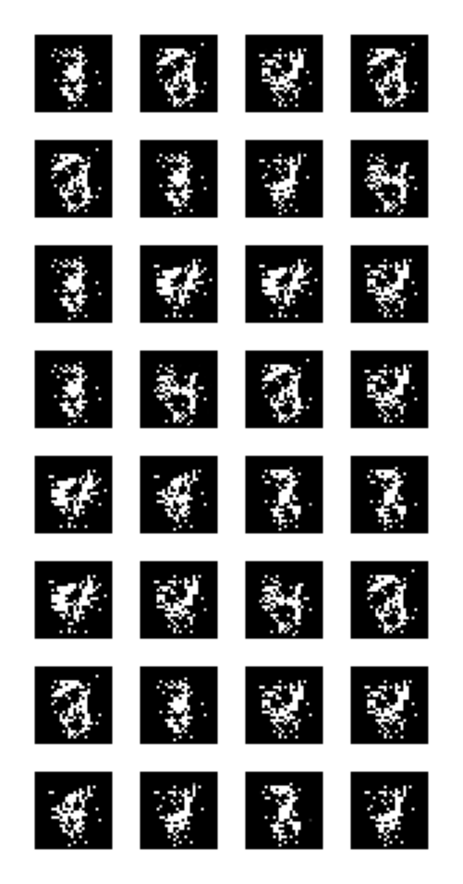

In [17]:
generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid(
    generated,
    nrow=4,
    padding=10,
    pad_value=1
)

img = np.transpose(
    grid.numpy(),
    (1, 2, 0)
)

fig = plt.figure(figsize=(16, 16))
plt.axis('off')
plt.imshow(img);

## Evaluation Metrics - Inception Score

In [16]:
import math
import torch
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision.models import inception_v3

In [17]:
net = inception_v3(pretrained=True).to(device)

In [22]:
def inception_score(images, batch_size):
    scores = []
    num_steps = int(math.ceil(float(len(images))))
    
    for i in range(num_steps):
        s = i * batch_size
        e = (i + 1) * batch_size
        
        mini_batch = images[s:e]
        batch = Variable(mini_batch)
              
        s, _ = net(batch)
        
        scores.append(s)
        
    scores = torch.cat(scores, 0)
    
    p_yx = F.softmax(scores, 1)
    p_y = p_yx.mean(0).unsqueeze(0).expand(p_yx.size(0), -1)
    
    KL_d = p_yx * (torch.log(p_yx) - torch.log(p_y))
    
    final_score = KL_d.mean()
    
    return final_score

In [ ]:
images = generator(test_set)
images = images.view(-1, 1, 28, 28)
images = images.repeat(1, 3, 1, 1)

res_images = F.interpolate(images, size=(299, 299))

score = inception_score(res_images, 3)

score.item()

In [26]:
torch.cuda.empty_cache()